In [43]:
import numpy as np
from matplotlib import pyplot as plt
import requests
from astropy.visualization.hist import hist as fancyhist
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import MeanShift
from sklearn import preprocessing
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix
import scipy.stats as stats

In [2]:
# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

print(names)

['GRB_name' 'GRB_name_Fermi' 'T0' 'ra' 'decl' 'pos_error' 'T90'
 'T90_error' 'T90_start' 'fluence' 'fluence_error' 'redshift' "'T100'"
 'GBM_located' 'mjd_(T0)']


In [3]:
T90 = np.array(data[6],dtype=float)
fluence = np.array(data[9],dtype=float)
logT90 = np.log10(T90[(T90>0) & (fluence>0)])
logfluence = np.log10(fluence[(T90>0) & (fluence>0)])

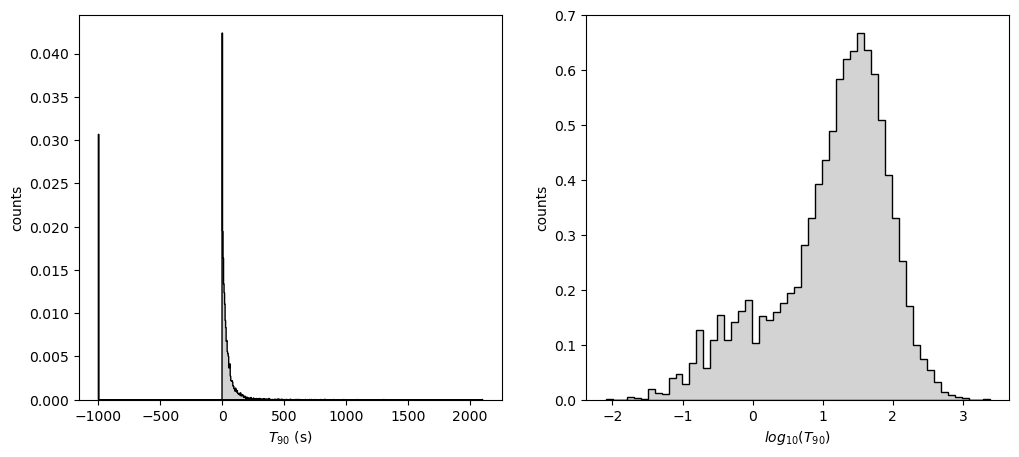

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

fancyhist(T90, bins="freedman", ax=axs[0], density=True, ec='black', fc='lightgrey', histtype='stepfilled')
axs[0].set_xlabel(r'$T_{90}$ (s)')
axs[0].set_ylabel('counts')


fancyhist(logT90, bins="freedman", ax=axs[1], density=True, ec='black', fc='lightgrey', histtype='stepfilled')
axs[1].set_xlabel(r'$log_{10}(T_{90})$')
axs[1].set_ylabel('counts')

plt.show()

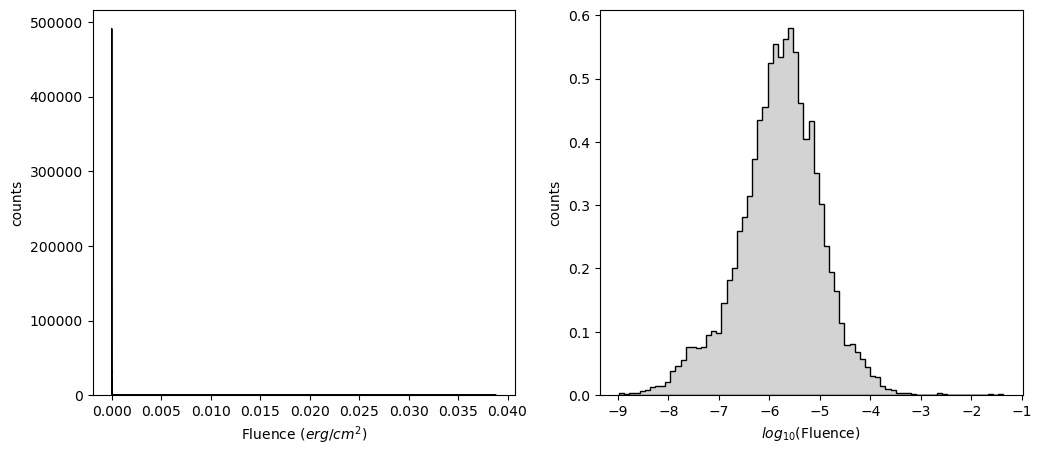

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

fancyhist(fluence[fluence > 0], bins="freedman", ax=axs[0], density=True, ec='black', fc='lightgrey', histtype='stepfilled')
axs[0].set_xlabel(r'Fluence $(erg/cm^2)$')
axs[0].set_ylabel('counts')

fancyhist(logfluence, bins="freedman", ax=axs[1], density=True, ec='black', fc='lightgrey', histtype='stepfilled')
axs[1].set_xlabel(r'$log_{10}$(Fluence)')
axs[1].set_ylabel('counts')

plt.show()

## KDE

In [6]:
def kde_sklearn(data, grid, bandwidth = 1.0, kernel = "linear"):
    kde_skl = KernelDensity(bandwidth = bandwidth, kernel = kernel)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(grid[:, np.newaxis])
    return np.exp(log_pdf)

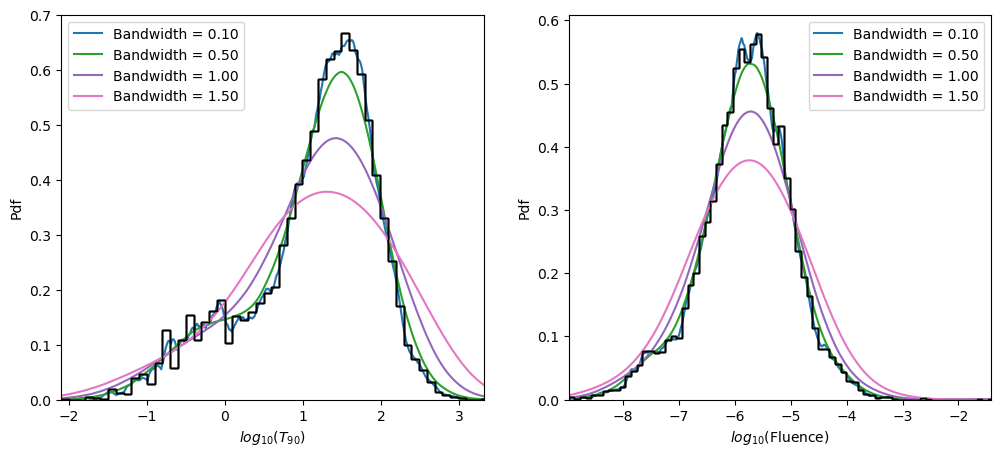

In [7]:
Tgrid = np.linspace(logT90.min(), logT90.max(), 10000) 
Fgrid = np.linspace(logfluence.min(), logfluence.max(), 10000) 
bandwidth = [0.1, 0.5, 1, 1.5]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
for b in bandwidth:
    pdf_T90 = kde_sklearn(logT90, Tgrid, bandwidth = b, kernel = 'epanechnikov') 
    axs[0].plot(Tgrid, pdf_T90, label = 'Bandwidth = %0.2f' %(b)) 
    fancyhist(logT90, bins="freedman", density=True, ax=axs[0], ec='black', histtype='step')
    axs[0].set_xlim(logT90.min(), logT90.max())
    axs[0].set_xlabel(r'$log_{10}(T_{90})$')
    axs[0].set_ylabel('Pdf')
    axs[0].legend(loc='upper left')
    
    pdf_fluence = kde_sklearn(logfluence, Fgrid, bandwidth = b, kernel = 'epanechnikov') 
    axs[1].plot(Fgrid, pdf_fluence, label = 'Bandwidth = %0.2f' %(b)) 
    fancyhist(logfluence, bins="freedman", density=True, ax=axs[1], ec='black', histtype='step')
    axs[1].set_xlim(logfluence.min(), logfluence.max())
    axs[1].set_xlabel(r'$log_{10}$(Fluence)')
    axs[1].set_ylabel('Pdf')
    axs[1].legend(loc='upper right')

plt.show()

In [8]:
def cross(data):
    grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv= K)
    grid.fit(data[:, None])
    return grid.best_params_['bandwidth']

In [9]:
bwrange = np.linspace(0.1, 1, 50)
K = 5
bw_T90 = cross(logT90)
bw_fluence = cross(logfluence)

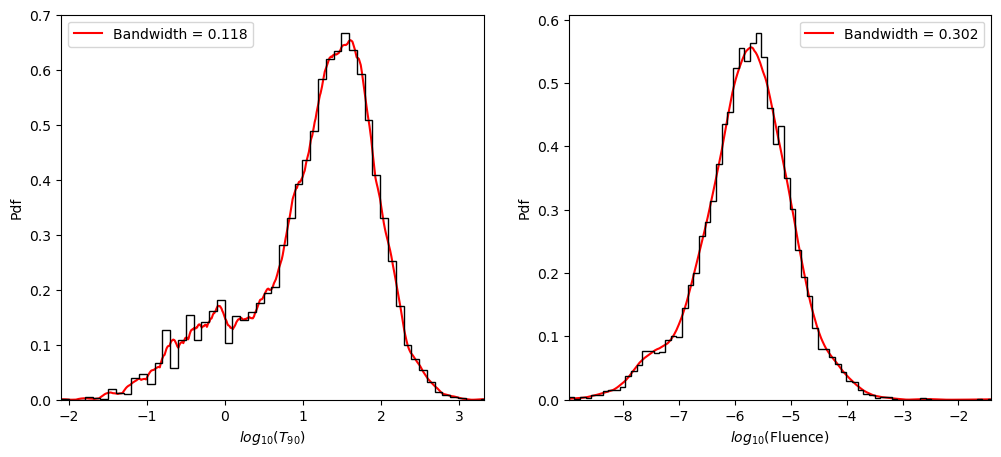

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

pdf_T90 = kde_sklearn(logT90, Tgrid, bandwidth = bw_T90, kernel = 'epanechnikov') 
axs[0].plot(Tgrid, pdf_T90, label = 'Bandwidth = %0.3f' %(bw_T90), color = 'red') 
fancyhist(logT90, bins="freedman", density=True, ax=axs[0], ec='black', histtype='step')
axs[0].set_xlim(logT90.min(), logT90.max())
axs[0].set_xlabel(r'$log_{10}(T_{90})$')
axs[0].set_ylabel('Pdf')
axs[0].legend(loc='upper left')

pdf_fluence = kde_sklearn(logfluence, Fgrid, bandwidth = bw_fluence, kernel = 'epanechnikov') 
axs[1].plot(Fgrid, pdf_fluence, label = 'Bandwidth = %0.3f' %(bw_fluence), color = 'red') 
fancyhist(logfluence, bins="freedman", density=True, ax=axs[1], ec='black', histtype='step')
axs[1].set_xlim(logfluence.min(), logfluence.max())
axs[1].set_xlabel(r'$log_{10}$(Fluence)')
axs[1].set_ylabel('Pdf')
axs[1].legend(loc='upper right')

plt.show()

## Clustering

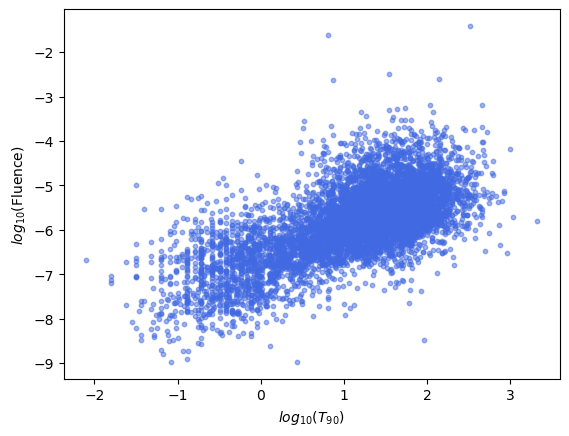

In [11]:
plt.scatter(logT90, logfluence, s = 10, color = 'royalblue', alpha = 0.5)
plt.xlabel(r'$log_{10}(T_{90})$')
plt.ylabel(r'$log_{10}$(Fluence)')
plt.show()

In [12]:
X = np.stack([logT90, logfluence], axis=1)

In [13]:
scaler = preprocessing.StandardScaler()
Y = scaler.fit_transform(X)

#### K-Means

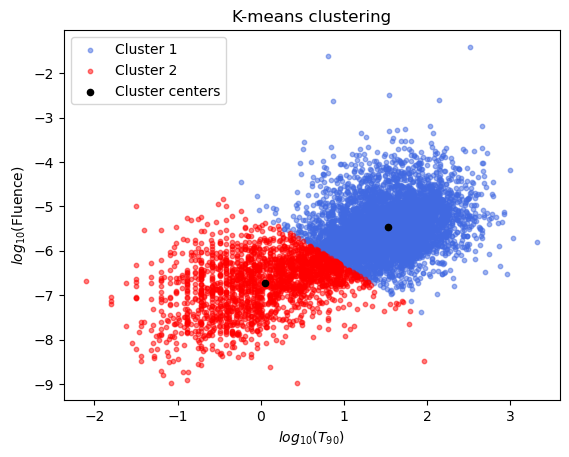

In [14]:
kmean = KMeans(n_clusters=2, n_init='auto')
kmean.fit(Y)
centers_k = scaler.inverse_transform(kmean.cluster_centers_) #location of the clusters
labels_k = kmean.predict(Y) #labels for each of the points
colors = ['royalblue', 'red']
for ii in range(2):
    plt.scatter(X[labels_k==ii,0], X[labels_k==ii,1], color=colors[ii] ,alpha=0.5, s=10, label='Cluster %i' %(ii+1))

plt.xlabel(r'$log_{10}(T_{90})$')
plt.ylabel(r'$log_{10}$(Fluence)')
plt.title('K-means clustering')
plt.scatter(centers_k[:,0],centers_k[:,1], color='black', s=20, label = 'Cluster centers')
plt.legend()
plt.show()

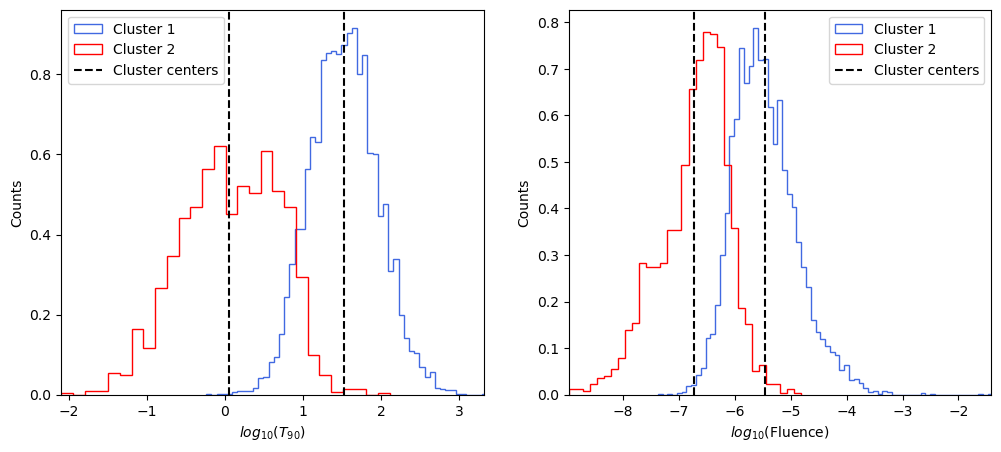

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

fancyhist(X[labels_k==0,0], bins="freedman", density=True, ax=axs[0], ec='royalblue', histtype='step', label='Cluster 1')
fancyhist(X[labels_k==1,0], bins="freedman", density=True, ax=axs[0], ec='red', histtype='step', label='Cluster 2')
axs[0].axvline(centers_k[0,0], color = 'black', ls = '--', label = 'Cluster centers')
axs[0].axvline(centers_k[1,0], color = 'black', ls = '--')
axs[0].set_xlim(logT90.min(), logT90.max())
axs[0].set_xlabel(r'$log_{10}(T_{90})$')
axs[0].set_ylabel('Counts')
axs[0].legend(loc='upper left')

fancyhist(X[labels_k==0,1], bins="freedman", density=True, ax=axs[1], ec='royalblue', histtype='step', label='Cluster 1')
fancyhist(X[labels_k==1,1], bins="freedman", density=True, ax=axs[1], ec='red', histtype='step', label='Cluster 2')
axs[1].axvline(centers_k[0,1], color = 'black', ls = '--', label = 'Cluster centers')
axs[1].axvline(centers_k[1,1], color = 'black', ls = '--')
axs[1].set_xlim(logfluence.min(), logfluence.max())
axs[1].set_xlabel(r'$log_{10}$(Fluence)')
axs[1].set_ylabel('Counts')
axs[1].legend(loc='upper right')

plt.show()

## NON CREDO ABBIA SENSO

In [45]:
print(stats.kstest(X[labels_k==1,0], 'norm'))
print(stats.kstest(X[labels_k==0,0], 'norm'))
print(stats.kstest(X[labels_k==1,1], 'norm'))
print(stats.kstest(X[labels_k==0,1], 'norm'))

KstestResult(statistic=0.13201719829775527, pvalue=9.49592551539012e-31, statistic_location=-0.721246399047171, statistic_sign=-1)
KstestResult(statistic=0.7502168728431158, pvalue=0.0, statistic_location=0.8394151926838935, statistic_sign=-1)
KstestResult(statistic=0.9999993560346693, pvalue=0.0, statistic_location=-4.84160734961288, statistic_sign=1)
KstestResult(statistic=0.9983554920768253, pvalue=0.0, statistic_location=-3.1920863132071124, statistic_sign=1)


#### Mean-Shift (CAPISCI PERCHE DA SOLO NON FUNZIONA)

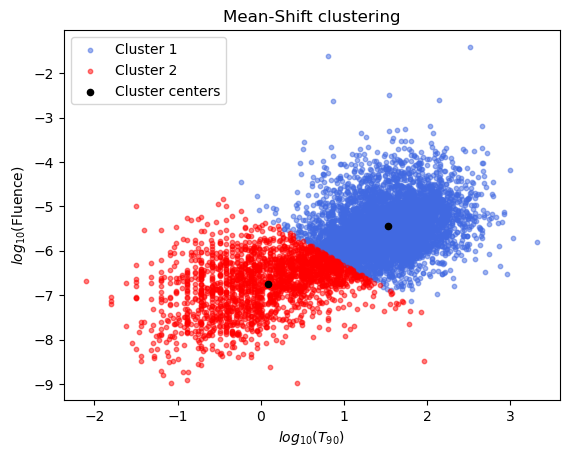

In [16]:
estimated_centers = kmean.cluster_centers_
#bandwidth = estimate_bandwidth(Y) # NON FUNZIONA
ms = MeanShift(bandwidth=0.1, bin_seeding=True, cluster_all=False, seeds = estimated_centers)
ms.fit(Y)
centers_m = scaler.inverse_transform(ms.cluster_centers_)
labels_m = ms.predict(Y)

for ii in range(2):
    plt.scatter(X[labels_m==ii,0], X[labels_m==ii,1], color=colors[ii] ,alpha=0.5, s=10, label='Cluster %i' %(ii+1))

plt.xlabel(r'$log_{10}(T_{90})$')
plt.ylabel(r'$log_{10}$(Fluence)')
plt.title('Mean-Shift clustering')
plt.scatter(centers_m[:,0],centers_m[:,1], color='black', s=20, label = 'Cluster centers')
plt.legend()
plt.show()

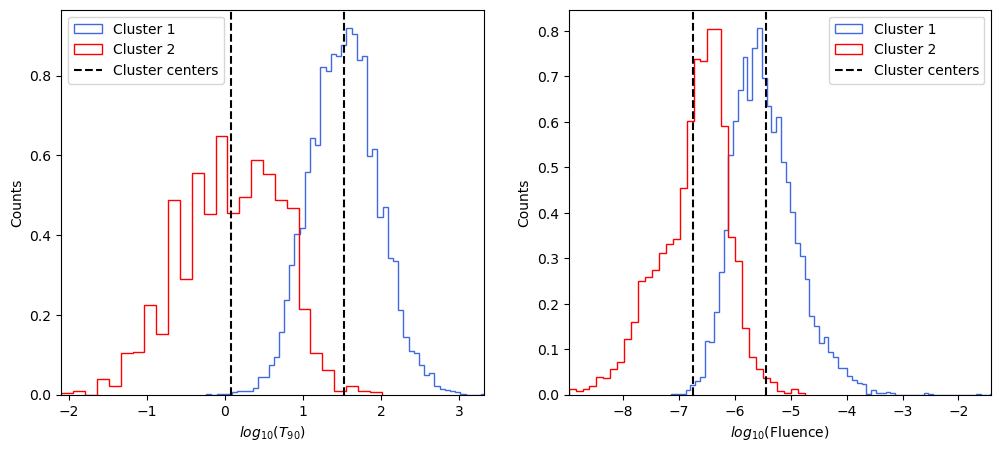

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

fancyhist(X[labels_m==0,0], bins="freedman", density=True, ax=axs[0], ec='royalblue', histtype='step', label='Cluster 1')
fancyhist(X[labels_m==1,0], bins="freedman", density=True, ax=axs[0], ec='red', histtype='step', label='Cluster 2')
axs[0].axvline(centers_m[0,0], color = 'black', ls = '--', label = 'Cluster centers')
axs[0].axvline(centers_m[1,0], color = 'black', ls = '--')
axs[0].set_xlim(logT90.min(), logT90.max())
axs[0].set_xlabel(r'$log_{10}(T_{90})$')
axs[0].set_ylabel('Counts')
axs[0].legend(loc='upper left')

fancyhist(X[labels_m==0,1], bins="freedman", density=True, ax=axs[1], ec='royalblue', histtype='step', label='Cluster 1')
fancyhist(X[labels_m==1,1], bins="freedman", density=True, ax=axs[1], ec='red', histtype='step', label='Cluster 2')
axs[1].axvline(centers_m[0,1], color = 'black', ls = '--', label = 'Cluster centers')
axs[1].axvline(centers_m[1,1], color = 'black', ls = '--')
axs[1].set_xlim(logfluence.min(), logfluence.max())
axs[1].set_xlabel(r'$log_{10}$(Fluence)')
axs[1].set_ylabel('Counts')
axs[1].legend(loc='upper right')

plt.show()

In [18]:
print('Confusion matrix between K-Means and Mean-Shift:')
print(confusion_matrix(labels_k, labels_m))

Confusion matrix between K-Means and Mean-Shift:
[[5300   29]
 [   1 1992]]


If we use the centres computed by K-means to estimate the centres in Mean-Shift, the two methods give very similar results.

## Gaussian Mixture

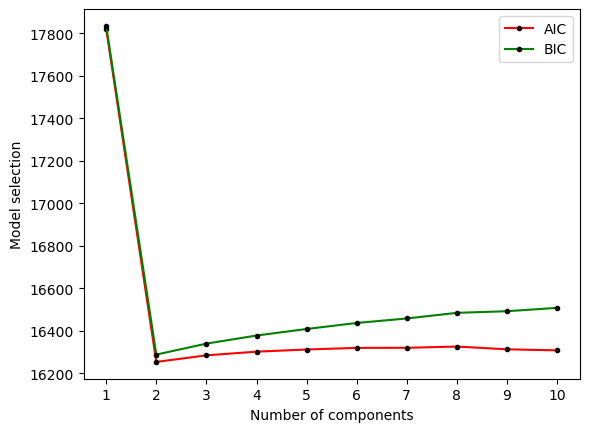

In [19]:
N = np.arange(1, 11)
aic = np.zeros(10)
bic = np.zeros(10)
for i in N:
    gm = GaussianMixture(n_components=i, random_state=0, covariance_type='full').fit(logT90[:, None])
    aic[i-1] = gm.aic(logT90[:, None])
    bic[i-1] = gm.bic(logT90[:, None])

plt.plot(N, aic, color = 'red', marker = '.', markerfacecolor = 'black', markeredgecolor = 'black', label = 'AIC')
plt.plot(N, bic, color = 'green', marker = '.', markerfacecolor = 'black', markeredgecolor = 'black', label = 'BIC')
plt.xticks(N)
plt.xlabel('Number of components')
plt.ylabel('Model selection')
plt.legend()
plt.show()

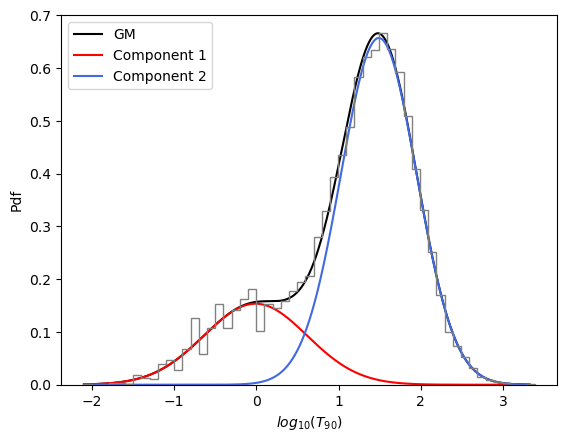

In [37]:
gm = GaussianMixture(n_components=2, random_state=0, covariance_type='full').fit(logT90[:, None])
responsabilities = gm.predict_proba(Tgrid[:, None])
log_like = gm.score_samples(Tgrid[:, None])
pdf = np.exp(log_like)
single_pdf = responsabilities*pdf[:, None]
means = gm.means_
labels_gm = gm.predict(logT90[:, None])

plt.plot(Tgrid, pdf, color = 'black', label = 'GM')
plt.plot(Tgrid, single_pdf[:, 0], color = 'red', label = 'Component 1')
plt.plot(Tgrid, single_pdf[:, 1], color = 'royalblue', label = 'Component 2')
fancyhist(logT90, bins="freedman", density=True, ec='grey', histtype='step')
plt.xlabel(r'$log_{10}(T_{90})$')
plt.ylabel('Pdf')
plt.legend(loc='upper left')
plt.show()

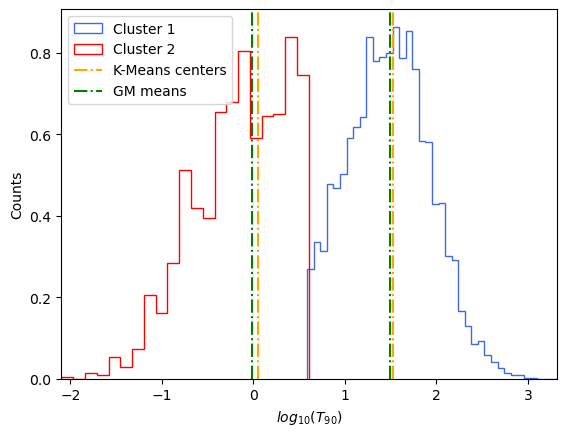

In [38]:
fancyhist(X[labels_gm==1,0], bins="freedman", density=True, ec='royalblue', histtype='step', label='Cluster 1')
fancyhist(X[labels_gm==0,0], bins="freedman", density=True, ec='red', histtype='step', label='Cluster 2')
plt.axvline(centers_k[0,0], color = 'orange', ls = '-.', label = 'K-Means centers')
plt.axvline(centers_k[1,0], color = 'orange', ls = '-.')
plt.axvline(means[0], color = 'green', ls = '-.', label = 'GM means')
plt.axvline(means[1], color = 'green', ls = '-.')
plt.xlim(logT90.min(), logT90.max())
plt.xlabel(r'$log_{10}(T_{90})$')
plt.ylabel('Counts')
plt.legend(loc='upper left')

plt.show()

In [31]:
print('Confusion matrix between K-Means and GaussianMixture:')
print(confusion_matrix(1 - labels_gm, labels_k))

Confusion matrix between K-Means and GaussianMixture:
[[5268  462]
 [  61 1531]]


## GM vs KDE

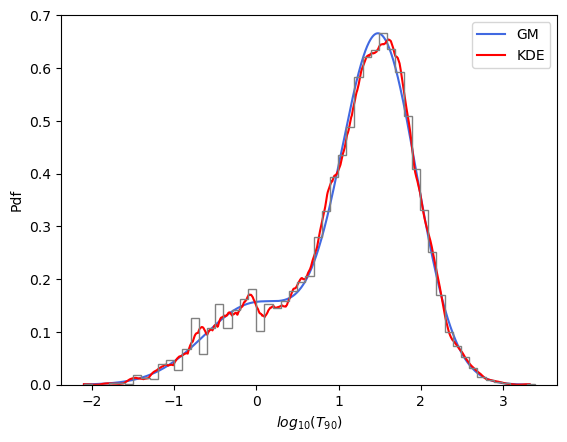

In [22]:
plt.plot(Tgrid, pdf, color = 'royalblue', label = 'GM')
plt.plot(Tgrid, pdf_T90, color = 'red', label = 'KDE') 
fancyhist(logT90, bins="freedman", density=True, ec='grey', histtype='step')
plt.xlabel(r'$log_{10}(T_{90})$')
plt.ylabel('Pdf')
plt.legend()
plt.show()

## NON SO SE è GIUSTO USARE LE PDF

In [46]:
print(stats.kstest(pdf, pdf_T90))

KstestResult(statistic=0.0692, pvalue=3.0806551184546733e-21, statistic_location=0.15037665901354672, statistic_sign=-1)


## 1-D Clustering

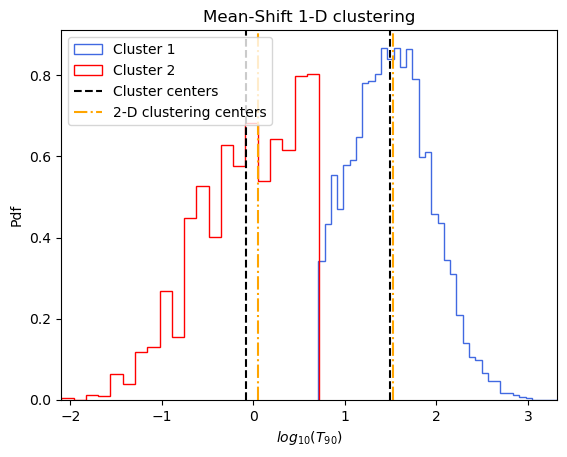

In [23]:
bandwidth = estimate_bandwidth(logT90[:, None])
ms_T90 = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=False)
ms_T90.fit(scaler.fit_transform(logT90[:, None]))
centers_T90 = scaler.inverse_transform(ms_T90.cluster_centers_)
labels_T90 = ms_T90.predict(scaler.fit_transform(logT90[:, None]))

fancyhist(X[labels_T90==0,0], bins="freedman", density=True, ec='royalblue', histtype='step', label='Cluster 1')
fancyhist(X[labels_T90==1,0], bins="freedman", density=True, ec='red', histtype='step', label='Cluster 2')
plt.axvline(centers_T90[1][0], color = 'black', ls = '--', label = 'Cluster centers')
plt.axvline(centers_T90[0][0], color = 'black', ls = '--')
plt.axvline(centers_k[0,0], color = 'orange', ls = '-.', label = '2-D clustering centers')
plt.axvline(centers_k[1,0], color = 'orange', ls = '-.')
plt.xlim(logT90.min(), logT90.max())
plt.xlabel(r'$log_{10}(T_{90})$')
plt.ylabel('Pdf')
plt.title('Mean-Shift 1-D clustering')
plt.legend(loc='upper left')

plt.show()

In [32]:
print('Confusion matrix between 1-d clustering and GaussianMixture:')
print(confusion_matrix(1-labels_gm, labels_T90))

Confusion matrix between 1-d clustering and GaussianMixture:
[[5539  191]
 [   0 1592]]


In [26]:
print('Confusion matrix between 1-d and 2-D clustering:')
print(confusion_matrix(labels_m, labels_T90))

Confusion matrix between 1-d and 2-D clustering:
[[5175  126]
 [ 364 1657]]
